In [1]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

In [2]:
#Voici la liste des genres musicaux représentés dans la notre base de données, on en compte 10.
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

#On commence par initialiser le dictionnaire avec les clés qui sont les noms des genres.
#On met autant de listes vides qu'il n'y a de genres.

In [3]:
# Créer un dictionnaire vide pour stocker les données audio pour chaque genre
audio_files = {}

# Itérer sur la liste des genres
for g in genres:
    # Créer une liste vide pour stocker les données audio pour le genre actuel
    audio_files[g] = []


In [4]:

# Itérer sur les fichiers audio dans le répertoire pour le genre actuel
for audio in os.listdir(f'./Data/genres_original/{g}'):
    # Charger les données audio en utilisant librosa et les ajouter à la liste pour le genre actuel
    audio_data = librosa.load(f'./Data/genres_original/{g}/{audio}')[0]
    audio_files[g].append(audio_data)

Maintenant que nous avons présentés toutes les features que l'on a considéré, construisons un pipeline pour créer une base d'apprentissage.\
Toutes ces features sont facilement calculables avec la librairie Python Librosa.\
_Ce pipeline nous servira aussi pour essayer nos modèles sur des fichiers musicaux externes (YouTube par exemple)._

In [5]:
def audio_pipeline(audio):
  
  features = []

  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))

  return features

On écrit les noms des features dans les colonnes d'un dataframe :

In [6]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

In [7]:
df = pd.DataFrame(columns = column_names)

In [8]:
i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1

In [9]:
df.to_csv('./Data/music.csv', index = False)

### Pandas

In [10]:
df = pd.read_csv("./Data/music.csv")

In [11]:
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,59810,1996.329188,4227.868737,-116.626270,109.25263,-23.163752,40.679480,-11.888837,23.152943,-15.409277,...,8.497991,-11.577597,2.197698,-6.180506,1.989980,-7.955889,2.083384,-2.392914,-1.541793,rock
1,36427,1529.290808,3271.448122,-111.252850,134.15211,-24.658049,41.542343,-3.075080,28.475187,-10.599550,...,9.940146,-4.680241,3.621828,-5.555472,3.361646,-4.956296,-1.477911,0.089316,-5.348198,rock
2,50935,1875.180216,3929.493150,-120.445526,117.58980,-27.635338,42.838066,-6.757944,21.642138,-12.103040,...,13.523022,-2.420074,6.712717,-3.155412,5.470172,-2.235662,1.061179,-1.654424,-0.035615,rock
3,28563,1421.355041,3042.701555,-156.545530,130.72420,-1.480792,36.234592,0.350913,31.955034,-0.621873,...,11.537828,-3.214253,5.058525,-1.785062,3.542804,-2.444864,-0.733025,-1.424127,0.644289,rock
4,27231,1345.841383,2939.157324,-127.970420,134.44084,1.020510,54.439240,-0.454471,35.814580,-10.856743,...,11.041861,-8.380609,2.107747,-6.346208,0.991749,-5.323317,-0.843005,-4.661474,-4.788684,rock


In [12]:
selector = VarianceThreshold(threshold=(0.2))

selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 
                                                    'mfcc1', 'mfcc2', 'mfcc3',
                                                    'mfcc4','mfcc5', 'mfcc6', 
                                                    'mfcc7', 'mfcc8', 'mfcc9',
                                                    'mfcc10','mfcc11', 'mfcc12',
                                                    'mfcc13', 'mfcc14', 'mfcc15',
                                                    'mfcc16', 'mfcc17', 'mfcc18', 
                                                    'mfcc19', 'mfcc20']])

df_sel_features = pd.DataFrame(selected_features)

Text(0.5, -0.15, 'Matrice de corrélation')

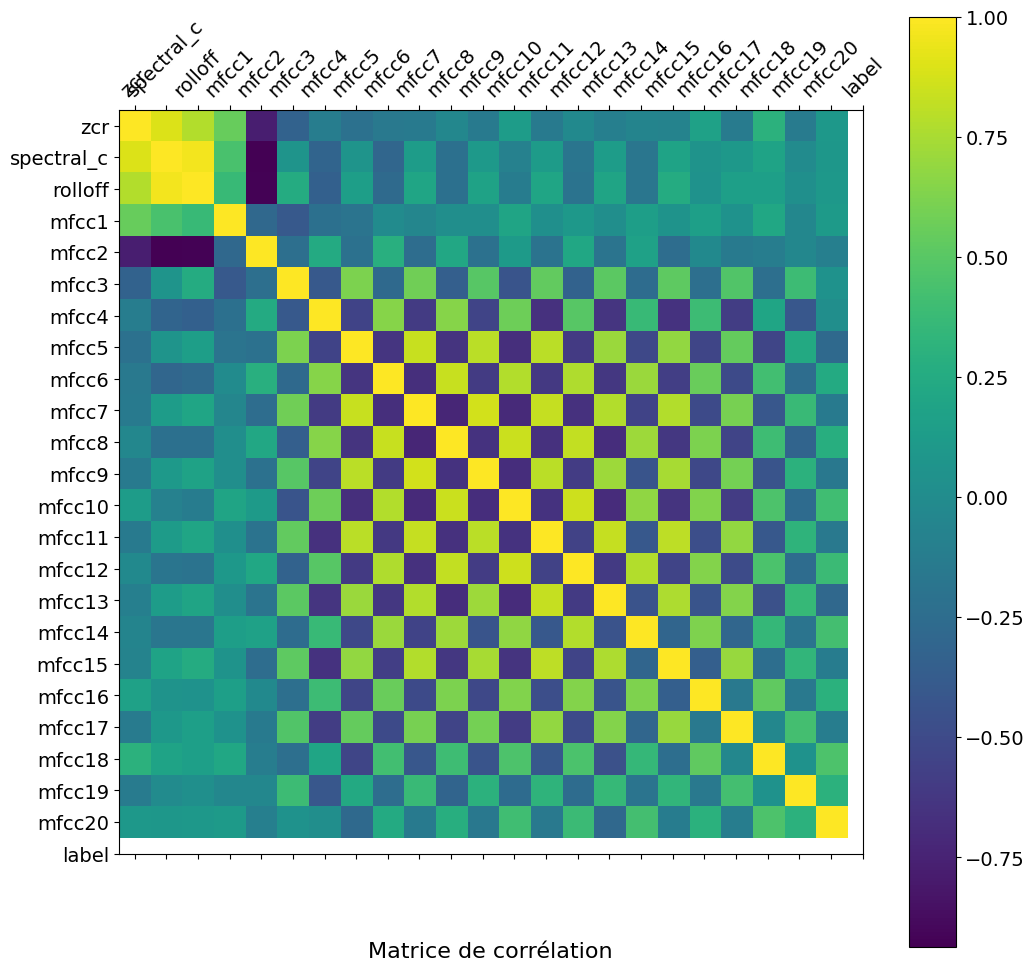

In [13]:
f = plt.figure(figsize=(12, 12))

plt.matshow(df_sel_features.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matrice de corrélation', fontsize=16, y=-0.15)

In [14]:
# y = df['label']
# values = np.unique(y,return_counts=True)[1]

# labels = genres
# sizes = values

# # Choix des couleurs

# colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf','#0584f2','#0aaff1','#edf259','#a79674']
 
# # Construction du diagramme et affichage des labels et des #fréquences en pourcentage

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# # Tracé du cercle au milieu

# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# # Affichage du diagramme

# ax1.axis('equal')  
# plt.tight_layout()
# plt.show()

### Création des images

In [15]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

In [16]:
for g in genres:
  for audio in os.listdir(f'./Data/genres_original/{g}'):
    audio_files[g].append(librosa.core.load(f'./Data/genres_original/{g}/{audio}'))

In [17]:
mel_specs = []

for g in genres:

  for audio in audio_files[g]:
  
    y = audio[0]
    sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
        
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
    if spect.shape[1] != 660:
      spect.resize(128,660, refcheck=False)

    mel_specs.append(spect)
        
X = np.array(mel_specs)

In [18]:
y_cnn = []

for i in range(len(genres)):
  y_cnn += 100*[i] # On a 100 images pour chaque genre
  # print(i)

y_cnn = np.array(y_cnn)

In [19]:
y_cnn = to_categorical(y_cnn)

x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn)

In [23]:
x_cnn_train /= np.min(x_cnn_train)
x_cnn_test /= np.min(x_cnn_train)

In [24]:
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 660, 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 660, 1)

### Conception de l’architecture du réseau et entraînement

In [27]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,660,1)))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, 
                 kernel_size=(3, 3), 
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 658, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 329, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 327, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 163, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 163, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 161, 32)       1

In [29]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [32]:
# history = model.fit(x_cnn_train,
#                     y_cnn_train,
#                     epochs=25,
#                     validation_data = (x_cnn_test,y_cnn_test))

In [33]:
# loss_curve = history.history["loss"]
# acc_curve = history.history["accuracy"]

# loss_val_curve = history.history["val_loss"]
# acc_val_curve = history.history["val_accuracy"]

# plt.plot(loss_curve, label="Train")
# plt.plot(loss_val_curve, label="Val")
# plt.legend(loc='upper left')
# plt.title("Loss")
# plt.show()

# plt.plot(acc_curve, label="Train")
# plt.plot(acc_val_curve, label="Val")
# plt.legend(loc='upper left')
# plt.title("Accuracy")
# plt.show()

In [31]:
# model.save('./model/')